In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wrf import getvar, interplevel, to_np, get_basemap, ll_to_xy,latlon_coords,latlon_coords, smooth2d,get_cartopy, cartopy_xlim, cartopy_ylim
import pandas as pd
from netCDF4 import Dataset
import netCDF4
import h5py as h5
import csv
from scipy import stats
import seaborn as sns
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units

In [2]:
def format_seconds_to_hhmmss(seconds):
    hours = seconds // (60*60)
    seconds %= (60*60)
    minutes = seconds // 60
    seconds %= 60
    return "%02i:%02i:%02i" % (hours, minutes, seconds)
def u_and_v(wind_direction, wind_speed):
    import math
    degree = ((270-wind_direction)*np.pi/180)
    u = math.cos(degree)*wind_speed
    v = math.sin(degree)*wind_speed
    return (u, v)
def Td(RH, es):
    e = RH * es
    Td = 1/((1/273.16) - (np.log(e/611)*461/2500000))
    return(Td)

In [3]:
def wrf_pres(P,PB):
    return (P+PB) #in Pa

def wrf_height(PH,PHB):
    return (PH+PHB)/9.81

def wrf_theta(PTEMP):
    return (PTEMP+300.)

def wrf_temp(THETA,PRES):
    return (THETA)*(PRES/1000.)**(.2854) # in hPa
def es(T):
    return (610.7*np.exp(((2500800+(4218-1870.4)*273.16)*(1/273.16-1/T)-(4218-1870.4)*np.log(T/273.16))/461.51))
def mean(data):
    mean = sum(data)/len(data)
    return(mean)

In [5]:
#open the Csv, read it
x = open("Crouch_04Z.csv", "r")

#Deliminate it with commas to grab the observed values
data = csv.reader(x, delimiter =",")
pres_list = []
temp_list = []
dew_list = []
u_ob = []
v_ob = []
ct = 0
pressure=1000
new_pressure = 1000
ct = 0
for line in data:
    if ct != 3:
        if new_pressure > 280 and line[5] != "//" and line[7] != "//":
            new_pressure = float(line[5])
            t = float(line[6])
            RH = float(line[7])* .01
            wind_speed = float(line[8])
            wind_direction = float(line[9])
            u_com, v_com = u_and_v(wind_direction, wind_speed)
            if t < 9800:
                sat_vap = es(t+273.16)
                dew = Td(RH, sat_vap) - 273.16      
            if new_pressure < 9800 and t < 9800 and dew < 9800:
                pres_list.append(new_pressure)
                temp_list.append(t)
                dew_list.append(dew)
                try:
                    u_ob.append(float(u_com))
                    v_ob.append(float(v_com))
                except:
                    i = 3
    ct = ct + 1
    if ct == 3:
        ct = 0
pres_list = np.array(pres_list)
temp_list = np.array(temp_list)

In [6]:
pres_list = np.array(pres_list)
tester = 702.8
tester_low = tester - 1
tester_high = tester + 1
ind = np.where(pres_list > tester_low)
final_list = pres_list[ind]
f_t = np.array(temp_list)[ind]
ind2 = np.where(final_list < tester_high)
print(np.mean(f_t[ind2]))
print(final_list[ind2][0])

-5.866666666666667
703.3


In [7]:
def file_info(name):
    filename = name
    picname = "numbercon_" + filename[19:27] + ".png"
    ncfile2 = Dataset(filename)
    ncfile = h5.File(filename, 'r')
    ds = netCDF4.Dataset(filename)
    cloud_mr = ncfile['QICE'][:].squeeze()+ncfile['QCLOUD'][:].squeeze() *1000
    P = ncfile['P'][:].squeeze()
    PB = ncfile['PB'][:].squeeze()
    PHB = ncfile['PHB'][:].squeeze()
    PH = ncfile['PH'][:].squeeze()
    lat = ncfile['XLAT'][:].squeeze()
    lon = ncfile['XLONG'][:].squeeze()
    PRES = wrf_pres(P,PB)/100
    HEIGHT = wrf_height(PH,PHB)
    THETA = ncfile['T'][:]
    THETA = wrf_theta(THETA)
    TEMP = wrf_temp(THETA,PRES).squeeze()
    TEMP= TEMP - 273.16
    return(cloud_mr,HEIGHT, PRES, ncfile2, TEMP)

In [8]:
file = Dataset('wcr_cloudtop_snowie_20170108.nc')
time_ct = file['time'][:]
ct_height = file['ct_height'][:]
ct_temp = file['ctt'][:]

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  This is separate from the ipykernel package so we can avoid doing imports until
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  after removing the cwd from sys.path.


In [9]:
#I want to append each CTH within a given second, then average them all together
second_height = []
second_temp = []
average_height = []
average_temp = []
hhmmss = []
#Start the second which is 11
check_sec = 11
#Starting with the first CTH
ct = 0
#Loop through all miliseconds
for sec in time_ct:
    #take the current second
    current_time = int(format_seconds_to_hhmmss(sec)[6:8])
    #If we're still in the current second, then add it to a list to be averaged later
    if current_time == check_sec:
        #Add the current height and temp to a list to be averaged later
        average_height.append(float(ct_height[ct]))
        average_temp.append(float(ct_temp[ct]))
        #move to the next step
        ct = ct + 1
    #If we've flipped to a new second, then average all the heights together
    if current_time != check_sec:
    #Find the mean of the CTH and T over that second
        av_height = np.mean(average_height)
        av_temp = np.mean(average_temp)
    #Add it to a list
        second_height.append(av_height)
        second_temp.append(av_temp)
    #Add what time we're at to a list to reference
        hhmmss.append(format_seconds_to_hhmmss(time_ct[ct-1]))
    #Make the second we just flipped to the new time
        check_sec = current_time
    #Move to the next step
        ct = ct + 1
    #Clear the array we build over the second
        average_height = []
        average_temp = []
        

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/cheyenne/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
new = []
for y in second_height:
    if np.isnan(y) != True:
        new.append(y)

new2 = []
for z in second_height:
    if z >=2500 and z <=5500:
        new2.append(z)


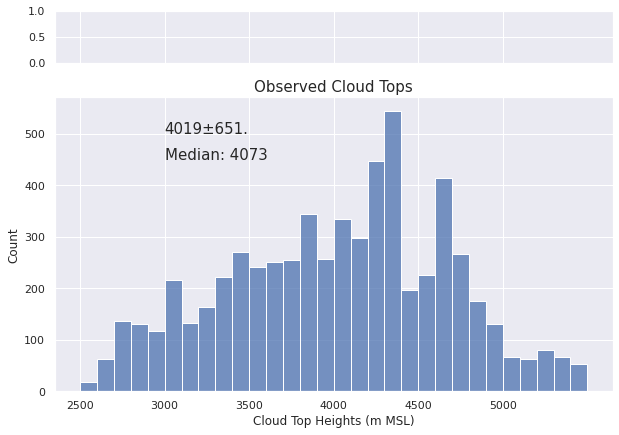

In [11]:
#fig, ax = plt.subplots(figsize =(10,7))
#ax.hist(second_height, bins = [2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750,7000])
sns.set(style="darkgrid")
df = second_height
xar = np.array([2500,3000,3500,4000,4500,5000])
fig, (ax_box, ax_hist) = plt.subplots(2, figsize = (10,7),sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
#sns.boxplot(df, ax=ax_box)
sns.histplot(data=df,  ax=ax_hist,binwidth = 100, binrange = [2500,5500])
ax_hist.set(xlabel='Cloud Top Heights (m MSL)')
height_mean = np.nanmean(np.array(new2))
height_mode = np.median(new2)
height_std = np.nanstd(new2)
plt.xticks([2500,3000,3500,4000,4500,5000])
q75, q25 = np.nanpercentile(second_height, [75,25])
iqr = q75-q25
string = str(height_mean)[0:4]+"±" + str(height_std)[0:4]
string2 = "Median: " + str(int(height_mode))[0:4]
string3 = "IQR: " + str(iqr)[0:4]
plt.text(3000, 500, string, fontsize = 15)
plt.text(3000, 450, string2, fontsize = 15)
#plt.text(5000, 500, string3, fontsize = 15)
plt.title("Observed Cloud Tops", fontsize = 15)
plt.show()
fig.savefig("Observed_CloudTop_Histogram_just5000.png")

In [12]:
file2 = Dataset('20170108c1.nc')
plane_altitude = file2['GALT'][:]
plane_pressure = file2['ps_weston'][:]
time = file2['TIME'][:]

In [13]:
#Leg 1 24512 25609
#Leg 2 25816 31613
#Leg 3 32000 32735
#Leg 4 33040 35057
#Leg 5 35329 40507
#Leg 6 40749 42909
#Leg 7 43153 44300
#Leg 8 44532 50652
#Leg 9 50928 52104
#Leg 10 52310 53130

In [14]:
leg_list =[]
#start of leg 1
l1_start = int(np.where(time == 24512)[0])
leg_list.append(l1_start)
#end of leg 1
l1_end = int(np.where(time == 25609)[0])
leg_list.append(l1_end)
#start of leg 2
l2_start = int(np.where(time == 25816)[0])
leg_list.append(l2_start)
#end of leg 2
l2_end = int(np.where(time == 31613)[0])
leg_list.append(l2_end)
#start leg 3
l3_start = int(np.where(time == 32000)[0])
leg_list.append(l3_start)
#end leg 3
l3_end = int(np.where(time == 32735)[0])
leg_list.append(l3_end)
#start leg 4
l4_start = int(np.where(time == 33040)[0])
leg_list.append(l4_start)
#end leg 4
l4_end = int(np.where(time == 35057)[0])
leg_list.append(l4_end)
#start leg 5
l5_start = int(np.where(time == 35329)[0])
leg_list.append(l5_start)
#end leg 5
l5_end = int(np.where(time == 40507)[0])
leg_list.append(l5_end)
#start leg 6
l6_start = int(np.where(time == 40749)[0])
leg_list.append(l6_start)
#end leg 6
l6_end = int(np.where(time == 42909)[0])
leg_list.append(l6_end)
#start leg 7
l7_start = int(np.where(time == 43153)[0])
leg_list.append(l7_start)
#end leg 7
l7_end = int(np.where(time == 44300)[0])
leg_list.append(l7_end)
#start leg 8
l8_start = int(np.where(time == 44532)[0])
leg_list.append(l8_start)
#end leg 8
l8_end = int(np.where(time == 50652)[0])
leg_list.append(l8_end)
#start leg 9
l9_start = int(np.where(time == 50928)[0])
leg_list.append(l9_start)
#end leg 9
l9_end = int(np.where(time == 52104)[0])
leg_list.append(l9_end)
#start leg 10
l10_start = int(np.where(time == 52310)[0])
leg_list.append(l10_start)
#end leg 10
l10_end = int(np.where(time == 53130)[0])
leg_list.append(l10_end)

In [15]:
lat_plane = file2['GLAT'][:]
lon_plane = file2['GLON'][:]

In [16]:
file_list = ["wrfout_d01_2017-01-08_02:45:00", "wrfout_d01_2017-01-08_03:10:00","wrfout_d01_2017-01-08_03:20:00", "wrfout_d01_2017-01-08_03:40:00","wrfout_d01_2017-01-08_04:00:00","wrfout_d01_2017-01-08_04:15:00","wrfout_d01_2017-01-08_04:35:00","wrfout_d01_2017-01-08_05:00:00","wrfout_d01_2017-01-08_05:15:00", "wrfout_d01_2017-01-08_05:25:00"]

In [17]:
leg_number = 1
#While the number of legs is less than 11
#Index to get the right leg start time at the start of the while loop
y = 0
countinue = True
up = 0
hit = False
looking_up = 0
modeled_cloudtop = []
current_model_y = 0
current_model_x = 0
list_index = 0
run_flag = True
modeled_cloudtop_temp = []
m_incloudtemp = []
m_incloudpres = []
up_list = []
full_envi_temp = []
envi_temp = []
envi_pres = []
full_m_temp = []
full_m_pres = []
full_envi_pres = []
temp_ct = []
temp_temp = []
leg_ct = []
leg_temp = []
while leg_number < 11:
    print(leg_number)
    cloud_mr, HEIGHT, PRES, ncfile2, TEMP = file_info(file_list[list_index])
    list_index = list_index + 1
    #Get the start index of the leg
    index = leg_list[y]
    #get the end index of the leg
    end = leg_list[y+1]
    
    while index < end:
        countinue = True
        y_flag = True
        x_flag = True
        #Get the current lat lon of the plane, then find the closest x,y point in the model
        lat_plane_current = lat_plane[index]
        lon_plane_current = lon_plane[index]
        model_y,model_x =ll_to_xy(ncfile2, lat_plane_current,lon_plane_current , meta = False)
        #Need to determine if the model point is already there
        if current_model_y == model_y:
            y_flag = False
        if current_model_x == model_x:
            x_flag = False
        if y_flag == True:
            run_flag = True
        if x_flag == True:
            run_flag = True
        if run_flag == True:
            current_model_y = model_y
            current_model_x = model_x
            while countinue == True:
                if up == 80:
                    countinue = False
                    up = 0
                test_mr = float(cloud_mr[up,model_x,model_y])
                
                if test_mr >= 0.06:
                    hit = True
                    looking_up = 0
                    up = up + 1
                    
                    #Begin finding modeled and environmental cloud temperatures
                    
                    #add cloud temperatures and modled temperatures
                    m_incloudtemp.append(TEMP[up,model_x,model_y])
                    m_incloudpres.append(PRES[up,model_x,model_y])
                    
                    #Take the current pressure we are at
                    curr_pres = PRES[up,model_x,model_y]
                    #Get the range of pressures (One mb above and below) to find in the Crouch Sounding
                    pres_low = curr_pres - 1
                    pres_high = curr_pres + 1
                    #Get the index of where the pressure is greater than the lowest pressure range
                    ind = np.where(pres_list > pres_low)
                    #New array of the pressure and temperature greater than the lowest range
                    final_p = pres_list[ind]
                    final_t = temp_list[ind]
                    
                    #Find the temperature of the environment in that new array
                    ind2 = np.where(final_p < pres_high)
                    e_temp = np.mean(final_t[ind2])
                    e_pres = np.mean(final_p[ind2])
                    #add this temperature to a list, that list will be added to another list at the end of the leg
                    envi_temp.append(e_temp)
                    envi_pres.append(e_pres)
                    
                    
                if test_mr < 0.06 and hit == True:
                    looking_up = looking_up + 1
                    up = up + 1
                    
                if hit == False:
                    up = up + 1
                    
                if looking_up == 25:
                    #Done finding the cloud top
                    countinue = False
                    up = up - 25
                    
                    #Get cloud top height and temperature
                    modeled_cloudtop.append(HEIGHT[up,model_x,model_y])
                    modeled_cloudtop_temp.append(TEMP[up, model_x,model_y])
                    
                    #Add the cloud's pressure and tempereature both from the model and the environment into a list
                    full_envi_temp.append(envi_temp)
                    full_envi_pres.append(envi_pres)
                    full_m_temp.append(m_incloudtemp)
                    full_m_pres.append(m_incloudpres)
                    #Filling a list to add to another list at the end of this leg
                    temp_ct.append(HEIGHT[up,model_x,model_y])
                    temp_temp.append(TEMP[up, model_x,model_y])
                    
                    #Clear them for the next cloud
                    envi_temp = []
                    m_incloudtemp = []
                    m_incloudpres =[]
                    envi_pres = []
                    up = 0
                    hit = False
            
            up = 0
            looking_up = 0
        run_flag = False
        index = index + 1
    #Add those temporary lists to leg_ct and leg_temp to get the tops and temps for each leg
    leg_ct.append(temp_ct)
    leg_temp.append(temp_temp)
    #Clear those temporary lists
    temp_ct = []
    temp_temp =[]
    leg_number = leg_number + 1

1
2
3
4
5
6
7
8
9
10


In [52]:
new2 = []
for r in modeled_cloudtop:
    if r >=2500 and r <=5500:
        new2.append(r)

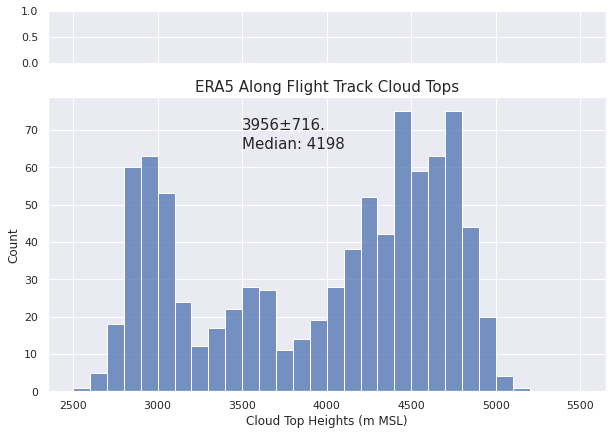

In [59]:
#fig, ax = plt.subplots(figsize =(10,7))
#ax.hist(modeled_cloudtop, bins = [2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000,5250,5500,5750,6000,6250,6500,6750,7000])
sns.set(style="darkgrid")
df = modeled_cloudtop
fig, (ax_box, ax_hist) = plt.subplots(2, figsize = (10,7),sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
#sns.boxplot(df, ax=ax_box)
sns.histplot(data=df, ax=ax_hist,binwidth = 100, binrange = [2500,5500])
ax_hist.set(xlabel='Cloud Top Heights (m MSL)')
height_mean = np.mean(np.array(new2))
height_mode = np.median(np.array(new2))
height_std = np.nanstd(new2)
q75, q25 = np.nanpercentile(df, [75,25])
iqr = q75-q25
string = str(height_mean)[0:4]+"±" + str(height_std)[0:4]
string2 = "Median: " + str(int(height_mode))[0:4]
#string3 = "IQR: " + str(iqr)[0:4]
plt.text(3500, 70, string, fontsize = 15)
plt.text(3500, 65, string2, fontsize = 15)
#plt.text(3500, 130, string3, fontsize = 15)
plt.title("ERA5 Along Flight Track Cloud Tops", fontsize = 15)
plt.show()
fig.savefig("ERA5_FTCloudTops.png")

In [19]:
print(modeled_cloudtop)

[4570.405, 4482.6484, 4553.462, 4476.1157, 4507.6973, 4474.625, 4509.5034, 4433.13, 4420.1743, 4426.024, 4445.423, 2999.0112, 3008.3364, 2782.6365, 2746.6914, 2746.553, 2702.35, 4240.121, 4439.563, 4525.2627, 4491.038, 4434.0244, 4313.4585, 3208.3945, 3191.582, 3130.5945, 2973.226, 2979.0454, 2890.2488, 4486.6523, 4526.825, 4592.0464, 4681.5005, 4709.23, 4711.7017, 4722.9727, 4642.2036, 3502.797, 3460.6873, 4485.452, 4697.1167, 4683.6196, 4866.797, 4881.3594, 4874.5815, 4823.1084, 4917.636, 4869.2383, 4698.8115, 3420.841, 3392.755, 3441.7402, 3472.8345, 3502.7017, 4561.779, 4642.74, 4640.6953, 4729.1978, 4723.576, 4764.9995, 4699.2715, 4690.0215, 4700.472, 4708.1113, 4631.278, 4659.069, 4726.9863, 4737.73, 4718.1133, 4781.0293, 4877.13, 4844.5815, 4735.741, 4742.1445, 4473.636, 4396.4497, 3109.1572, 3123.5798, 4435.8125, 4599.661, 4707.9653, 4793.3984, 4723.5767, 4708.193, 4693.022, 4699.399, 4618.326, 3652.5996, 3604.6929, 3638.5151, 3711.693, 2681.729, 2848.2075, 2811.46, 2928.8562, 

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


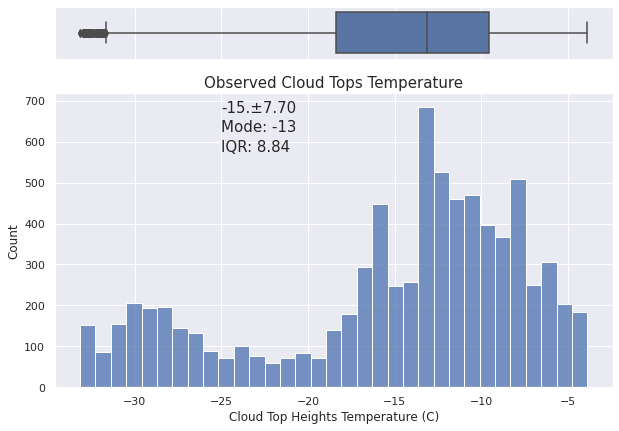

In [20]:
#fig, ax = plt.subplots(figsize =(10,7))
#ax.hist(second_temp)
sns.set(style="darkgrid")
df = second_temp
fig, (ax_box, ax_hist) = plt.subplots(2, figsize = (10,7),sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(df, ax=ax_box)
sns.histplot(data=df, ax=ax_hist)
ax_hist.set(xlabel='Cloud Top Heights Temperature (C)')
height_mean = np.nanmean(np.array(df))
height_mode = stats.mode(df)
height_std = np.nanstd(df)
q75, q25 = np.nanpercentile(df, [75,25])
iqr = q75-q25
string = str(height_mean)[0:4]+"±" + str(height_std)[0:4]
string2 = "Mode: " + str(int(height_mode[0]))[0:4]
string3 = "IQR: " + str(iqr)[0:4]
plt.text(-25, 670, string, fontsize = 15)
plt.text(-25, 625, string2, fontsize = 15)
plt.text(-25, 575, string3, fontsize = 15)
plt.title("Observed Cloud Tops Temperature", fontsize = 15)
plt.show()
fig.savefig("Observed_CloudTopTemp_Histogram_ALLLEGS")

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


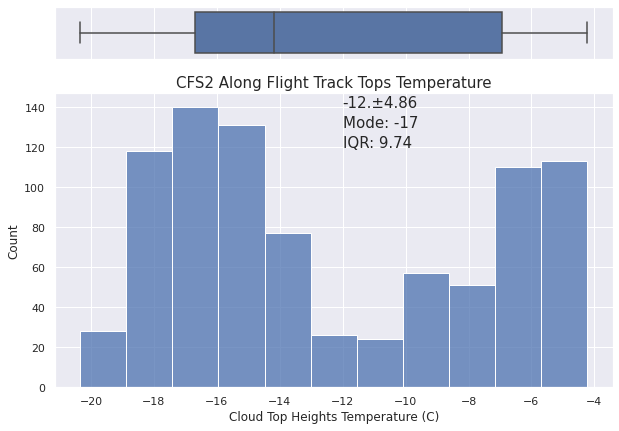

In [21]:
#fig, ax = plt.subplots(figsize =(10,7))
#ax.hist(modeled_cloudtop_temp)
sns.set(style="darkgrid")
df = modeled_cloudtop_temp
fig, (ax_box, ax_hist) = plt.subplots(2, figsize = (10,7),sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
sns.boxplot(df, ax=ax_box)
sns.histplot(data=df, ax=ax_hist)
ax_hist.set(xlabel='Cloud Top Heights Temperature (C)')
height_mean = np.nanmean(np.array(df))
height_mode = stats.mode(df)
height_std = np.nanstd(df)
q75, q25 = np.nanpercentile(df, [75,25])
iqr = q75-q25
string = str(height_mean)[0:4]+"±" + str(height_std)[0:4]
string2 = "Mode: " + str(int(-17))[0:4]
string3 = "IQR: " + str(iqr)[0:4]
plt.text(-12, 140, string, fontsize = 15)
plt.text(-12, 130, string2, fontsize = 15)
plt.text(-12, 120, string3, fontsize = 15)
plt.title("CFS2 Along Flight Track Tops Temperature", fontsize = 15)
plt.show()
fig.savefig("CFS2_FTTopsTEMP")

In [ ]:
min(second_temp)

In [ ]:
#full_envi_temp[0][0:10])
#full_envi_pres[0][0:10])
#full_m_temp[0][0:10])
#full_m_pres[0][0:10])

In [18]:
full_envi_temp = np.array(full_envi_temp)
full_m_temp = np.array(full_m_temp)
p = 0
rmse_list = []
countz = 0
while p < 875:
    difference = (np.array(full_envi_temp[p][:]) - np.array(full_m_temp[p][:]))**2
    rmse_list.append(sum(difference))
    countz = countz + len(full_envi_temp[p][:])
    p = p + 1

RMSE_CLOUDS = (sum(rmse_list)/countz)**(1/2)

print(RMSE_CLOUDS)

1.138976342291388


In [ ]:
#Leg 1 24511 25609
#Leg 2 25816 31613
#Leg 3 32000 32735
#Leg 4 33040 35057
#Leg 5 35329 40507
#Leg 6 40749 42909
#Leg 7 43153 44300
#Leg 8 44532 50652
#Leg 9 50928 52104
#Leg 10 52310 53130
#second_height
import math
#second_temp
observed_height_leg = []
observed_temp_leg = []
time_ct = file['time'][:]
temp_heights = []
temp_temps = []
acounter = 0

#Going through each timestep
for t in hhmmss:
    #Getting rid of the :
    current_time = int(t.replace(':',''))
    #Getting rid of nans
    if math.isnan(second_height[acounter]) == False:
        temp_heights.append(second_height[acounter])
    if math.isnan(second_temp[acounter]) == False:
        temp_temps.append(second_temp[acounter])
    #If the current time is the end of a flight leg, then add it to the observed height list, and clear the temporary height list
    if current_time == 25609:
        observed_height_leg.append(temp_heights)
        observed_temp_leg.append(temp_temps)
        temp_temps = []
        temp_heights = []
    if current_time == 31613:
        observed_height_leg.append(temp_heights)
        observed_temp_leg.append(temp_temps)
        temp_temps = []
        temp_heights = []
    if current_time == 32735:
        observed_height_leg.append(temp_heights)
        observed_temp_leg.append(temp_temps)
        temp_temps = []
        temp_heights = []
    if current_time == 35057:
        observed_height_leg.append(temp_heights)
        observed_temp_leg.append(temp_temps)
        temp_temps = []
        temp_heights = []
    if current_time == 40507:
        observed_height_leg.append(temp_heights)
        observed_temp_leg.append(temp_temps)
        temp_temps = []
        temp_heights = []
    if current_time == 42909:
        observed_height_leg.append(temp_heights)
        observed_temp_leg.append(temp_temps)
        temp_temps = []
        temp_heights = []
    if current_time == 44300:
        observed_height_leg.append(temp_heights)
        observed_temp_leg.append(temp_temps)
        temp_temps = []
        temp_heights = []
    if current_time == 50652:
        observed_height_leg.append(temp_heights)
        observed_temp_leg.append(temp_temps)
        temp_temps = []
        temp_heights = []
    if current_time == 52104:
        observed_height_leg.append(temp_heights)
        observed_temp_leg.append(temp_temps)
        temp_temps = []
        temp_heights = []
    if current_time == 53120:
        observed_height_leg.append(temp_heights)
        observed_temp_leg.append(temp_temps)
        temp_temps = []
        temp_heights = []
    acounter = acounter + 1

        
        
    

In [45]:
print(len(observed_height_leg[0]))
print(len(leg_ct[0]))

612
91


In [ ]:
l1_m_median= statistics.median(leg_ct[0])
l1_m_25 = np.percentile(leg_ct[0], 25)
l1_m_75 =np.percentile(leg_ct[0], 75)
l1_p_median= statistics.median(plane_lwc_L1list)
l1_p_25 = np.percentile(plane_lwc_L1list, 25)
l1_p_75 = np.percentile(plane_lwc_L1list, 75)
l2_m_median= statistics.median(model_lwc_L2list)
l2_m_25 = np.percentile(model_lwc_L2list, 25)
l2_m_75 = np.percentile(model_lwc_L2list, 75)
l2_p_median= statistics.median(plane_lwc_L2list)
l2_p_25 = np.percentile(plane_lwc_L2list, 25)
l2_p_75 = np.percentile(plane_lwc_L2list, 75)
l3_m_median= statistics.median(model_lwc_L3list)
l3_m_25 = np.percentile(model_lwc_L3list, 25)
l3_m_75 = np.percentile(model_lwc_L3list, 75)
l3_p_median= statistics.median(plane_lwc_L3list)
l3_p_25 = np.percentile(plane_lwc_L3list, 25)
l3_p_75 = np.percentile(plane_lwc_L3list, 75)
l4_m_median= statistics.median(model_lwc_L4list)
l4_m_25 = np.percentile(model_lwc_L4list, 25)
l4_m_75 = np.percentile(model_lwc_L4list, 75)
l4_p_median= statistics.median(plane_lwc_L4list)
l4_p_75 = np.percentile(plane_lwc_L4list, 75)
l4_p_25 = np.percentile(plane_lwc_L4list, 25)
l5_m_median= statistics.median(model_lwc_L5list)
l5_m_25 = np.percentile(model_lwc_L5list, 25)
l5_m_75 = np.percentile(model_lwc_L5list, 75)
l5_p_median= statistics.median(plane_lwc_L5list)
l5_p_75 = np.percentile(plane_lwc_L5list, 75)
l5_p_25 = np.percentile(plane_lwc_L5list, 25)
l6_m_median= statistics.median(model_lwc_L6list)
l6_m_25 = np.percentile(model_lwc_L6list, 25)
l6_m_75 = np.percentile(model_lwc_L6list, 75)
l6_p_median= statistics.median(plane_lwc_L6list)
l6_p_75 = np.percentile(plane_lwc_L6list, 75)
l6_p_25 = np.percentile(plane_lwc_L6list, 25)
l7_m_median= statistics.median(model_lwc_L7list)
l7_m_25 = np.percentile(model_lwc_L7list, 25)
l7_m_75 = np.percentile(model_lwc_L7list, 75)
l7_p_median= statistics.median(plane_lwc_L7list)
l7_p_25 = np.percentile(plane_lwc_L7list, 25)
l7_p_75 = np.percentile(plane_lwc_L7list, 75)
l8_m_median= statistics.median(model_lwc_L8list)
l8_m_25 = np.percentile(model_lwc_L8list, 25)
l8_m_75 = np.percentile(model_lwc_L8list, 75)
l8_p_median= statistics.median(plane_lwc_L8list)
l8_p_25 = np.percentile(plane_lwc_L8list, 25)
l8_p_75 = np.percentile(plane_lwc_L8list, 75)
l9_m_median= statistics.median(model_lwc_L9list)
l9_m_25 = np.percentile(model_lwc_L9list, 25)
l9_m_75 = np.percentile(model_lwc_L9list, 75)
l9_p_median= statistics.median(plane_lwc_L9list)
l9_p_25 = np.percentile(plane_lwc_L9list, 25)
l9_p_75 = np.percentile(plane_lwc_L9list, 75)
l10_m_median= statistics.median(model_lwc_L10list)
l10_m_25 = np.percentile(model_lwc_L10list, 25)
l10_m_75 = np.percentile(model_lwc_L10list, 75)
l10_p_median= statistics.median(plane_lwc_L10list)
l10_p_25 = np.percentile(plane_lwc_L10list, 25)
l10_p_75 = np.percentile(plane_lwc_L10list, 75)